# **INFO 6350 Final Project**

### By: Casey Kaufman (cpk57) and Wally Chang (wsc46)

# Introduction 

Movies are an extraordinary reflection of societal norms, beliefs, and narratives. They're not simply a means of entertainment but a cultural artifact that captures the essence of human experiences throughout history. These cinematic creations delve into the human condition, portraying the complexities of emotions, relationships, and societal dynamics. As a fusion of artistry and storytelling, films transcend language barriers and geographical boundaries, making them an influential medium accessible to diverse audiences worldwide.

Our fascination with movies stems from their ability to encapsulate the spirit of various eras. From depicting historical events with artistic flair to weaving imaginative tales that resonate with universal truths, each film contributes to the mosaic of our collective consciousness. As  movie enthusiasts, we were drawn to explore the intricate web of words that form the backbone of these beloved films.

In undertaking this Text-Mining final project, our primary aim was to delve deeper into the linguistic fabric of cinema. Words, after all, are the fundamental building blocks of these narratives. We sought to unravel the nuances of dialogue and narration, understanding how they contribute to the richness of storytelling that captivates audiences and leaves an indelible mark on cultural landscapes.

The dataset that we will be working this throughout our project is a compilation of movies spanning from 1940 to present day. We chose the movies for our dataset as each of the 5 movies that were nominated for best original screenplay for that year-- making note of which movies won and lost. Our dataset consists of the movie title, the entire script of the movie (taken from the closed captions in order to only capture the dialogue and narration), the year, and if the movie won or loss the award. 

Our project is broken up into the following: 
1. Data Collection and Processing
2. Basic Data Exploration and Pre-Processing
3. Unsupervised Cluster Analysis
4. Baseline Supervised Classification Tasks for Winners/Losers
5. Baseline Supervised Classification Tasks Across Decades 
6. BERT Classification Task Across Deacdes
7. Sentiment Analysis between Decades & Winners/Losers


# Objectives/hypothesis

- Overall, our group is hoping to gain a deeper understanding of the way that movies are written. At a high level, we want to see if there is a difference between the writing of movies if they have won or lost the best picture award, and over the different decades. We anticipate that there will be more notable differences between movies over time rather than between winners and losers. 
- We would like to explore the different features that appear to be the top features for movies of the different decades and between ones that have won and lost the best picture award. This will give us a deeper understanding of the movies and how they are actually written between these two groups.
- We would like to analyse the sentiment of movies from different decades as well as between winners and losers. We anticipate that there will be different sentiments between the decades and winners and losers. However, we are hesitant because we are looking at closed captions so we are weary that the sentiment that will be captured will be more related to the plot of the movie than the writing style. 

# Corpus Creation

When beginnning to create a corpus on the rationale that movies and their scripts contain significant and meaningful information and difference between each other and between eras of filmmaking. Thus, we began to think about how we could capture "good" writing and quantify it. Immediately, we thought to the Academy Awards.

The Academy Awards, also known as the Oscars, are an annual set of prestigious film awards presented by the Academy of Motion Picture Arts and Sciences (AMPAS). The awards recognize excellence in various categories within the film industry, including acting, directing, and screenplay writing. Within the awards, there are 23 categories or subsets presented. These categories cover various aspects of filmmaking, including acting, directing, writing, and technical achievements. The major categories include Best Picture, Best Director, Best Actor, Best Actress, Best Supporting Actor, Best Supporting Actress, Best Original Screenplay, Best Adapted Screenplay, and awards for achievements in cinematography, editing, production design, costume design, makeup and hairstyling, sound editing, sound mixing, visual effects, and more.

From here, we conducted research to see which of the Academy Awards would be best suited for our proposed text mining project. Quickly, we realized that The Academy Award for Best Original Screenplay fit the bill. The Academy Award for Best Original Screenplay specifically honors outstanding achievement in crafting an original screenplay that has not been adapted from previously published material. This category celebrates the creativity and storytelling prowess of writers who contribute unique and compelling narratives to the world of cinema. The winner is selected through a voting process by members of the Academy, making it one of the most coveted accolades in the film industry.

For this award, there are 5 nominees for each year, and out of them, one winner. To collect this data, we manually copy and pasted the Best Original Screenplay Wikipedia page, a repository of all the nominees and winners from 1940 to 2022, into an Excel spreadsheet. From here, we performed manual data cleaning to even out the rows and columns, as well as adding an additional wins/losses column, inputting 0 if the movie did not win and 1 if the movie did win.

Then, we had to collect the actual text from each movie. We realized quickly that it was difficult or impossible to collect movie scripts from each one of the movies. Very rare is the full script of a movie released (containing actor cues, audio cues, & cinematic direction/descriptions). Thus, we had to settle for an alternative, readily available source - movie subtitles. Though we realized we would be losing a lot of contextual information for the actual filming of the movie and potentially reasons why a movie performed well during Academy voting, it was the only way for us to effectively collect a comprehensive amount of data in the allotted time.

Therefore, we manually downloaded .SRT files from online subtitle repositories for each of the movies, and finally, converted them into text files within Python.

In [2]:
import chardet
import os
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD   
from nltk.tokenize import word_tokenize
import nltk
from fuzzywuzzy import fuzz
import random
import time
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer, DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
%pip install --upgrade accelerate

## 1. Data Collection and Cleaning

The dataset that we will be working with has the following information: 
1. Movie Title
2. Movie Text (from captions) 
3. Year Movie Released 
4. Year Movie Nominated 
5. Win or Loss of Best Picture 

To compile this dataset, we first manually compiled an excel sheet that included each of the 5 movie nominations for the year-- noting the movie that was victorious. After doing this, we compliled a folder where we placed the .srt files of each of the movies captions. The captions were found and downloaded from serching the web manually and adding the file to the folder. Once all of the files had been added, we wrote the function below in order to automate the process of translating our .srt files into a dataframe that we could manipulate. 

In [3]:
def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read()

    result = chardet.detect(raw_data)
    return result['encoding']

def srt_to_text(srt_file_path):
    encoding_attempts = ['utf-8', 'ISO-8859-1', 'utf-16', ]

    for encoding in encoding_attempts:
        try:
            with open(srt_file_path, 'r', encoding=encoding) as file:
                lines = file.readlines()

            text = ""
            current_line = ""
            is_time_line = True

            for line in lines:
                line = line.strip()

                if not line:
                    is_time_line = True
                    continue

                if is_time_line:
                    is_time_line = False
                    continue

                current_line += line + " "

                # If the line ends with a punctuation indicating the end of a sentence
                if line.endswith(('.', '!', '?')):
                    text += current_line + "\n"
                    current_line = ""

            return text.strip()
        except UnicodeDecodeError:
            None

    # If none of the encodings work
    print(f"Unable to decode file: {srt_file_path}")
    return None

def process_srt_files_in_folder(folder_path):
    result_dict = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".srt"):
            srt_file_path = os.path.join(folder_path, filename)
            text_content = srt_to_text(srt_file_path)

            if text_content is not None:
                file_dict = {"name": filename, "text": text_content}
                result_dict.append(file_dict)

    return result_dict

# Example usage for a folder containing SRT files
wally = '/Users/wally/Library/CloudStorage/OneDrive-Personal/Documents/Cornell/1. Fourth Year/INFO 6350 - Text Mining History and Literature/INFO6350_Final_Project/srt_files'
casey = '/Users/caseykaufman/Documents/GitHub/INFO6350_Final_Project/srt_files'

folder_path = casey

result_dictionary = process_srt_files_in_folder(folder_path)

In [4]:
movie_subtitles_df = pd.DataFrame(result_dictionary)
movie_subtitles_df.head(5)

,name,text
0,Sunset Blvd. (1950)_english.srt,"00:01:29,840 --> 00:01:33,634 Yes, this is Sun..."
1,Diner.1982.720p.BluRay.x264-AMIABLE.srt,"00:00:43,084 --> 00:00:44,653 - A little bit s..."
2,Road.To.Utopia.1945.1080p.BluRay.x264-[YTS.AM]...,"00:00:29,613 --> 00:00:33,402 For those of you..."
3,Tender Mercies (1983).srt,"00:00:26,180 --> 00:00:28,100 - Here, give me ..."
4,Ghandi.1982.1080p.BluRay.x264.YIFY.srt,"00:01:57,534 --> 00:02:00,036 There are more t..."


**Once translated into a dataframe, the movie scripts with their filenames were in the format above. The first step we took was simply removing the time stamps of the dataset.**

In [5]:
# Removal of timestamps
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'\d{2}:\d{2}:\d{2},\d{3} --> \d{2}:\d{2}:\d{2},\d{3}[\s-]+', '\n', regex=True)
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'<font.*?>|<\/font>', '', regex=True)
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'\bdownloaded.*?|subtitles downloaded.*?|http.*?|www.*?', '', regex=True, flags=re.IGNORECASE)

In [6]:
pd.options.display.max_rows = 400

**Next, we extracted the years from the movie titles that were downloaded.**

In [7]:
# Find the year of each movie from the file name
years = []
for name_index in range(len(movie_subtitles_df['name'])):
    found_year = False
    for letter_index in range(len(movie_subtitles_df['name'][name_index])):
        if movie_subtitles_df['name'][name_index][letter_index:letter_index+2] == '19' and movie_subtitles_df['name'][name_index][letter_index:letter_index+4].isdigit() or movie_subtitles_df['name'][name_index][letter_index:letter_index+2] == '20' and movie_subtitles_df['name'][name_index][letter_index:letter_index+4].isdigit():
            y = movie_subtitles_df['name'][name_index][letter_index:letter_index+4]
            years.append(y)
            found_year = True
            break
    if not found_year:
        years.append('na')

# Add new column with corresponding years
movie_subtitles_df['years'] = years

**We then needed to retrieve the actual movie title out of the (quite) messy .srt file names in order to be able to attach an actual movie to the text. This was done below leveraging regex.**

In [8]:
#cleaning names
pattern1= r'^([^\d(]+)(?:\.\d{4}| \(\d{4}\))?\.?[^\w]*'
pattern2 = r'^[^a-zA-Z]*(.*?)\.[a-zA-Z]{3}\b'
pattern3 = r'^[^a-zA-Z]*(.*?)\.[a-zA-Z]{3}-'

clean_names = []
for file_name in movie_subtitles_df['name']:
    match = re.match(pattern1, file_name) or re.match(pattern2, file_name) or re.match(pattern3, file_name)
    if match:
        extracted_name = match.group(1).replace('.', ' ')
        clean_names.append(extracted_name)
    else:
        print("Name extraction pattern not found for:", file_name)
        
new = [name.split('WWW')[0].strip() if 'WWW' in name else name for name in clean_names]
clean_names = [x.replace('-','') for x in new]

In [9]:
movie_subtitles_df['Movie Name'] = clean_names

**The next obstacle that we had to address was now matching up whether or not the movies were winners or losers of the award for future analyses that we were hoping to perform. In order to do this, we referenced our original excel file that we used to track the movies that we would use. When iterating through this file, we used fuzzy matching to find the index that the movie lived in by comparing the names we had unocvered to the titles of the movies saved in our files. Once the index was found, we would take the win/loss value from that index in excel and add it to the row in the dataframe we were working with.**

In [10]:
#adding win/loss
excel = pd.read_csv('scripts.csv')

#getting index values
highest = []
for films in clean_names: 
    similarity = []
    indexes = []
    for all_films in excel['Film']:
        sim = fuzz.ratio(str(films), str(all_films))
        similarity.append(sim)
    highest.append(similarity.index(max(similarity)))
    
movie_name_check = []
win_loss = []
for idx in highest:
    value1 = excel.loc[idx,'Film']
    value2 = excel.loc[idx,'Win']
    movie_name_check.append(value1)
    win_loss.append(value2)
    
movie_subtitles_df['Similarity Calc Name'] = movie_name_check
movie_subtitles_df['Win or Loss'] = win_loss

**Below is the cleaned and compiled dataset that we will be using for the rest of our project.**

In [11]:
movie_subtitles_df.head()

,name,text,years,Movie Name,Similarity Calc Name,Win or Loss
0,Sunset Blvd. (1950)_english.srt,"\nYes, this is Sunset Boulevard, Los Angeles, ...",1950,Sunset Blvd,Sunset Boulevard,1.0
1,Diner.1982.720p.BluRay.x264-AMIABLE.srt,\nA little bit softer now - Shout \nA little b...,1982,Diner,Diner,0.0
2,Road.To.Utopia.1945.1080p.BluRay.x264-[YTS.AM]...,"\nFor those of you who don't go to the movies,...",1945,Road To Utopia,Road to Utopia,0.0
3,Tender Mercies (1983).srt,"\nHere, give me the bottle. \n- Go to hell. \n...",1983,Tender Mercies,Tender Mercies,1.0
4,Ghandi.1982.1080p.BluRay.x264.YIFY.srt,\nThere are more than yesterday. \n\nHe will b...,1982,Ghandi,Gandhi,1.0


# 2. Basic Data Exploration and Pre-Processing

In [12]:
# Tokenize the text in each row
tokenized_text = movie_subtitles_df['text'].apply(word_tokenize)

# Add the tokenized text to a new column
movie_subtitles_df['tokenized_text'] = tokenized_text

## Count Tokens in Each Movie Script

In [13]:
# Add the number of tokens in a movie script to a new column titled 'num_tokens'
movie_subtitles_df['num_tokens'] = [len(movie_subtitles_df['tokenized_text'][i]) for i in range(len(movie_subtitles_df['text']))]

In [14]:
movie_subtitles_df.head()

,name,text,years,Movie Name,Similarity Calc Name,Win or Loss,tokenized_text,num_tokens
0,Sunset Blvd. (1950)_english.srt,"\nYes, this is Sunset Boulevard, Los Angeles, ...",1950,Sunset Blvd,Sunset Boulevard,1.0,"[Yes, ,, this, is, Sunset, Boulevard, ,, Los, ...",15458
1,Diner.1982.720p.BluRay.x264-AMIABLE.srt,\nA little bit softer now - Shout \nA little b...,1982,Diner,Diner,0.0,"[A, little, bit, softer, now, -, Shout, A, lit...",16868
2,Road.To.Utopia.1945.1080p.BluRay.x264-[YTS.AM]...,"\nFor those of you who don't go to the movies,...",1945,Road To Utopia,Road to Utopia,0.0,"[For, those, of, you, who, do, n't, go, to, th...",15171
3,Tender Mercies (1983).srt,"\nHere, give me the bottle. \n- Go to hell. \n...",1983,Tender Mercies,Tender Mercies,1.0,"[Here, ,, give, me, the, bottle, ., -, Go, to,...",9986
4,Ghandi.1982.1080p.BluRay.x264.YIFY.srt,\nThere are more than yesterday. \n\nHe will b...,1982,Ghandi,Gandhi,1.0,"[There, are, more, than, yesterday, ., He, wil...",15581


#### Most Frequently Occurring Tokens

In [15]:
token_lists = movie_subtitles_df['tokenized_text']

# Flatten the list of lists into a single list of tokens
all_tokens = [token for sublist in token_lists for token in sublist]

# Use Counter to count the occurrences of each token
token_counts = Counter(all_tokens)

# Get the 50 most common tokens
top_50_tokens = token_counts.most_common(50)

# Display the result
print("Top 50 most frequent tokens:")
for token, count in top_50_tokens:
    print(f"{token}: {count}")

Top 50 most frequent tokens:
.: 414286
,: 232214
I: 141293
?: 116160
you: 115244
the: 92202
to: 78841
's: 73480
a: 69298
n't: 53126
>: 52743
<: 52724
-: 51210
it: 48673
...: 48166
!: 46899
of: 40656
You: 38629
that: 38238
do: 37603
and: 37378
in: 35179
me: 31524
is: 30225
i: 26309
/i: 25798
on: 24445
'm: 23886
for: 23345
're: 21855
have: 21703
know: 21232
your: 20688
be: 20360
What: 20156
this: 20117
It: 19824
was: 19415
my: 18844
we: 18309
with: 17123
not: 17103
are: 16685
'll: 16383
he: 15184
what: 15001
all: 14702
No: 13869
like: 13832
right: 13581


#### Number of Tokens by Year

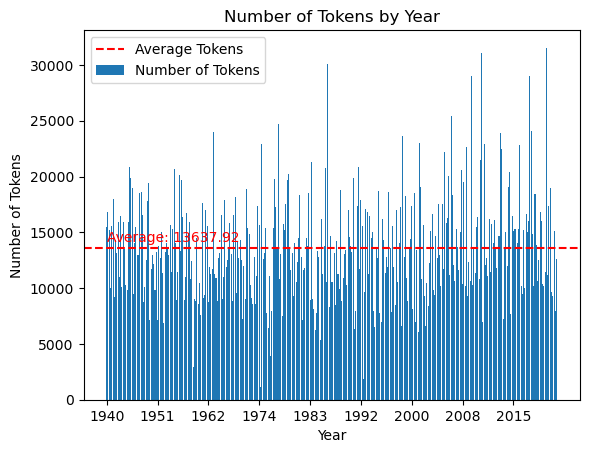

In [16]:
import matplotlib.pyplot as plt

# Sort DataFrame by 'years' in ascending order
movie_subtitles_df = movie_subtitles_df.sort_values(by='years')

# Set x-axis ticks to show only once every other 20 years
step = 40  # Adjust the step value as needed
plt.xticks(range(0, len(movie_subtitles_df['years']), step), movie_subtitles_df['years'][::step])

# Create bar chart
plt.bar(movie_subtitles_df.index, movie_subtitles_df['num_tokens'], label='Number of Tokens')
plt.xlabel('Year')
plt.ylabel('Number of Tokens')
plt.title('Number of Tokens by Year')

# Plot the average line
average_tokens = movie_subtitles_df['num_tokens'].mean()
plt.axhline(y=average_tokens, color='red', linestyle='--', label='Average Tokens')

# Display the average value
plt.text(0.5, average_tokens + 500, f'Average: {average_tokens:.2f}', color='red', ha='left')

plt.legend()
plt.show()

#### Minimum number of tokens vs maximum number of tokens

Minimum number of tokens in all scripts:  1125
Maximum number of tokens in all scripts:  31547


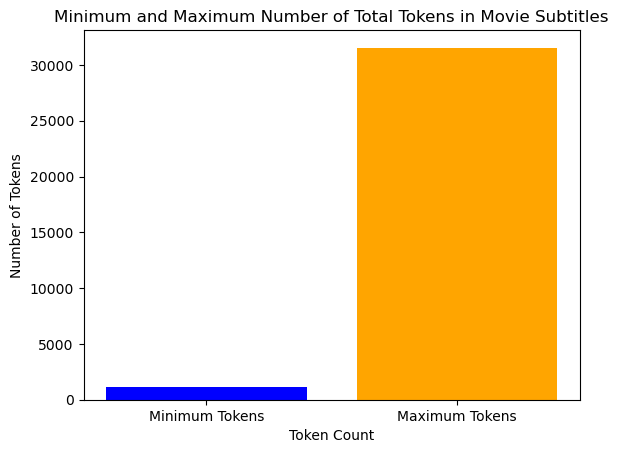

In [17]:
# Minimum number of tokens versus maximum number of tokens
min_tokens = min(movie_subtitles_df['num_tokens'])
max_tokens = max(movie_subtitles_df['num_tokens'])

print('Minimum number of tokens in all scripts: ', min_tokens)
print('Maximum number of tokens in all scripts: ', max_tokens)

# Plotting the data
labels = ['Minimum Tokens', 'Maximum Tokens']
values = [min_tokens, max_tokens]

plt.bar(labels, values, color=['blue', 'orange'])
plt.xlabel('Token Count')
plt.ylabel('Number of Tokens')
plt.title('Minimum and Maximum Number of Total Tokens in Movie Subtitles')
plt.show()

#### Longest paragraph/line versus shortest paragraph/line, split on line breaks

Longest Paragraph length: 
284

Shortest Paragraph length: 
2


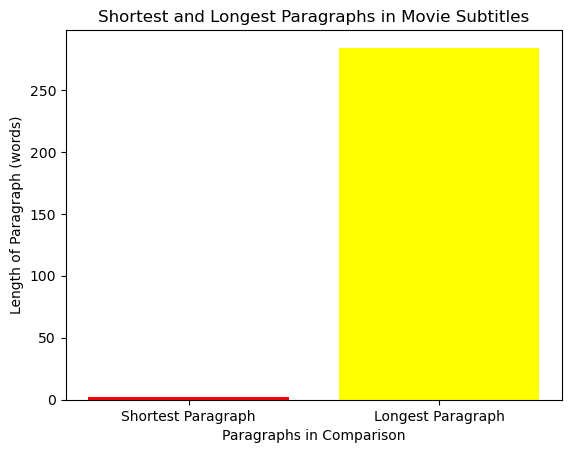

In [18]:
# Find the longest and shortest paragraphs
max_length = 0
min_length = 100000000
longest_paragraph = ''
shortest_paragraph = ''

for index, row in movie_subtitles_df.iterrows():
    paragraphs = row['text'].split('\n')  # Assuming paragraphs are separated by '\n'
    
    for paragraph in paragraphs:
        paragraph_length = len(paragraph)
        
        # Update longest paragraph
        if paragraph_length > max_length:
            max_length = paragraph_length
            longest_paragraph = paragraph

        # Update shortest paragraph
        if paragraph_length < min_length and paragraph.strip():  # Check for non-empty paragraphs
            min_length = paragraph_length
            shortest_paragraph = paragraph

print("Longest Paragraph length: ")
print(len(longest_paragraph))

print("\nShortest Paragraph length: ")
print(len(shortest_paragraph))

# Plotting the data
labels = ['Shortest Paragraph', 'Longest Paragraph']
values = [len(shortest_paragraph), len(longest_paragraph)]

plt.bar(labels, values, color=['red', 'yellow'])
plt.xlabel('Paragraphs in Comparison')
plt.ylabel('Length of Paragraph (words)')
plt.title('Shortest and Longest Paragraphs in Movie Subtitles')
plt.show()

#### See Cosine Similarity Scores Between Movies

We were curious to see how similar movie subtitle scripts are to each other in general using cosine similarity scoring, first with stop words, then without stop words.

In [19]:
# Create a TF-IDF vectorizer to conduct similarity test with stop word removal
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(movie_subtitles_df['text'])

# Compute cosine similarity between movies
similarity_matrix = cosine_similarity(tfidf_matrix)

# Print the average similarity scores
print("Average Cosine Similarity Score Without Removing Stopwords: ")
print(np.mean(similarity_matrix))

Average Cosine Similarity Score Without Removing Stopwords: 
0.6701699398505467


In [20]:
# Create a TF-IDF vectorizer to conduct similarity test with stop word removal
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(movie_subtitles_df['text'])

# Compute cosine similarity between movies
similarity_matrix = cosine_similarity(tfidf_matrix)

# Print the average similarity scores
print("Average Cosine Similarity Score, Removing Stopwords: ")
print(np.mean(similarity_matrix))

Average Cosine Similarity Score, Removing Stopwords: 
0.17171533811168818


It appears that when stop words are not removed, movie subtitles are quite similar, scoring .67 in cosine similarity. This seems logical, as subtitles are largely dialogue, and there are frequently occurring pieces of speech in all dialogue. When stop words are removed, the average cosine similarity score drops to .17, which is also logical. This leads us to believe that during classification tasks, models might find it difficult to differentiate between winners and losers of the Academy Award for Best Original Screenplay based on tokens if stop words are not removed, since it appears that there is significant similarity between subtitles.

#### Visualizing the 700 most frequently occurring token unigrams between winners and losers, using truncated SVD

In [21]:
# Vectorizer to get token unigram counts
vectorizer = TfidfVectorizer(max_features=700, stop_words='english')
X = vectorizer.fit_transform(movie_subtitles_df['text'])

# Convert the matrix to DataFrame
features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Set features and labels
labels = movie_subtitles_df['Win or Loss']
features = features  # No length normalization

# Display the shapes of features and labels
print('Features Shape:', features.shape, 'Labels Shape:', labels.shape)

Features Shape: (355, 700) Labels Shape: (355,)


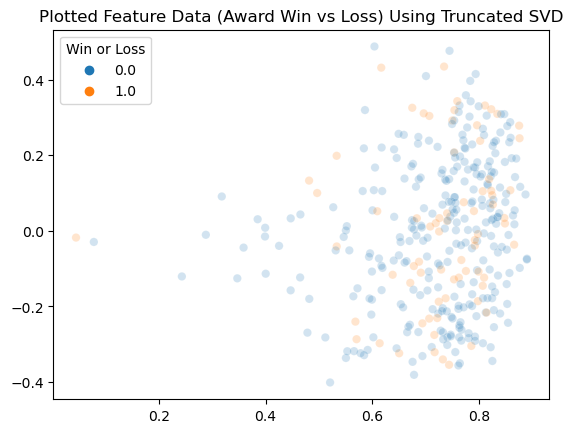

In [22]:
# Plot the feature data, default: 2 dimensional truncated SVD
features_reduced = TruncatedSVD().fit_transform(features)
sns.scatterplot(x=features_reduced[:,0], y=features_reduced[:,1], hue=labels, alpha=0.2)
plt.title('Plotted Feature Data (Award Win vs Loss) Using Truncated SVD')
plt.show()

Viewing the plotted feature data reduced by truncated SVD, we do not see any significant difference or segmentation in features. Both wins and losses are plotted closely together, and there are no discernible patterns either.

## Create Chunks of Tokens out of the Paragraphs

Since there is a significant discrepancy between the lengths of the shortest "paragraph" and the longest "paragraph", we felt like creating standardized chunks of tokens to feed into our vectorizer could help normalize our vectors and provide more informative outputs.

In [23]:
def generate_chunks(paragraphs, movie, year, win_loss, chunk_size=200):
    chunks = []
    chunk_movie_name = []
    chunk_year = []
    chunk_win_loss = []

    for i in range(len(paragraphs)):
        text = paragraphs.iloc[i]  # Extract the text from the Series
        newsletter_type = movie.iloc[i]
        date = year.iloc[i]
        result = win_loss.iloc[i]

        # Split the text into paragraphs using '\n'
        text_paragraphs = text.split('\n')

        current_chunk = []
        current_chunk_movie_name = []
        current_chunk_win_loss = []

        for paragraph in text_paragraphs:
            # Check if the length of the paragraph exceeds the chunk size
            if len(paragraph) > chunk_size:
                chunks.append(paragraph)
                chunk_movie_name.append(newsletter_type)
                chunk_year.append(date)
                chunk_win_loss.append(result)
            else:
                # If not, add the paragraph to the current chunk
                current_chunk.append(paragraph)
                current_chunk_movie_name.append(newsletter_type)
                current_chunk_win_loss.append(result)

                # Check if the current chunk size exceeds the specified limit
                if len(' '.join(current_chunk)) > chunk_size:
                    chunks.append(' '.join(current_chunk))
                    chunk_year.extend([date])
                    chunk_movie_name.append(newsletter_type)
                    chunk_win_loss.append(result)
                    current_chunk = []
                    current_chunk_movie_name = []
                    current_chunk_win_loss = []

        # Add any remaining paragraphs to the last chunk
        if current_chunk:
            chunks.append(' '.join(current_chunk))
            chunk_year.extend([date])
            chunk_movie_name.append(newsletter_type)
            chunk_win_loss.append(result)

    return chunks, chunk_movie_name, chunk_year, chunk_win_loss

# Generate chunks
text_chunks, chunk_movie_name, chunk_year, chunk_win_loss = generate_chunks(
    movie_subtitles_df['text'],
    movie_subtitles_df['Similarity Calc Name'],
    movie_subtitles_df['years'],
    movie_subtitles_df['Win or Loss']
)


In [24]:
# Visualize token chunk features
chunks_df = pd.DataFrame({
    'Text Chunk': text_chunks,
    'Movie Name': chunk_movie_name,
    'Year': chunk_year,
    'Win or Loss': chunk_win_loss
})

chunks_df

,Text Chunk,Movie Name,Year,Win or Loss
0,What's new? - Same old daily bunkeroo. Mr....,Foreign Correspondent,1940,0.0
1,Bah! Foreign correspondent! I could get mo...,Foreign Correspondent,1940,0.0
2,is a daily guessing game. I want some facts...,Foreign Correspondent,1940,0.0
3,You've written a book on economics or somethi...,Foreign Correspondent,1940,0.0
4,"I want a reporter, somebody who doesn't know ...",Foreign Correspondent,1940,0.0
...,...,...,...,...
90449,"<i>What you mean?</i> <i>Nein, nein, nein...<...",Triangle of Sadness,2022,0.0
90450,Abigail! - Yaya! Yaya! Abigail! Abigai...,Triangle of Sadness,2022,0.0
90451,"It's been there the whole fucking time, Abiga...",Triangle of Sadness,2022,0.0
90452,- Ah... Sorry. Let's go. I need to wee-w...,Triangle of Sadness,2022,0.0


In [25]:
# TFIDF Vectorizer with idf on
chunk_vectorizer = TfidfVectorizer(use_idf=True, norm=None)

In [26]:
# Vectorize chunked texts
X_chunked = chunk_vectorizer.fit_transform(text_chunks)

# 3. Unsupervised Cluster Analysis

An initial unsupervised cluster analysis was performed to identify any discernible patterns in the data prior to further processing. Potential areas of pattern appearance are hypothesized to potentially be: winners/losers, movie release time period, and differences in sentiment.

First, we used the elbow method to try and identify the optimal number of clusters for which to perform the KMeans cluster analysis. For each value of K, we are calculating WCSS (Within-Cluster Sum of Square). WCSS is the sum of the squared distance between each point and the centroid in a cluster.

/Users/caseykaufman/opt/anaconda3/envs/3350/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Plotting the Elbow curve took:254.2s 


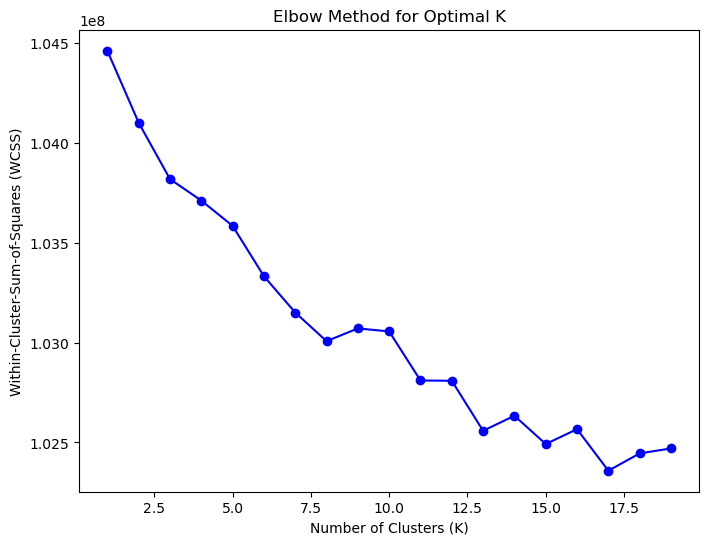

In [27]:
# Using the elbow method to find the optimal number of clusters
# Referenced: https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/

wcss = [] 
t0 = time.time()
for i in range(1, 20): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_chunked) 
    wcss.append(kmeans.inertia_)
t1 = time.time()
    
print("Plotting the Elbow curve took:{:.1f}s ".format(t1-t0))

# Plotting the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster-Sum-of-Squares (WCSS)')
plt.show()

In [28]:
y_pred = KMeans(n_clusters=2, n_init='auto').fit_predict(X_chunked)

In [29]:
# Plotting function
def plot_compare(X, labels, title, alpha=0.2):
    '''
    Takes an array of object data, a list of cluster labels, a title string, and an optional alpha value.
    Reduces dimensions to 2 if necessary and plots the clustering with and without coloring by label.
    Returns nothing.
    '''
    if X.shape[1] > 2:
        svd = TruncatedSVD(n_components=3)
        X_2d = svd.fit_transform(X)
    else:
        X_2d = X

    # initialize figsize in prompt
    plt.figure(figsize=(12, 6))

    # left subplot, alpha value in function cell
    plt.subplot(121)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=alpha)
    plt.title("Dimension-Reduced Unclustered Data")

    # right subplot, same coordinate data and supplied cluster labels, alpha value in function cell
    plt.subplot(122)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, alpha=alpha)
    plt.title("Data with Clustering")

    # Set the common title for the entire figure
    plt.title(title)

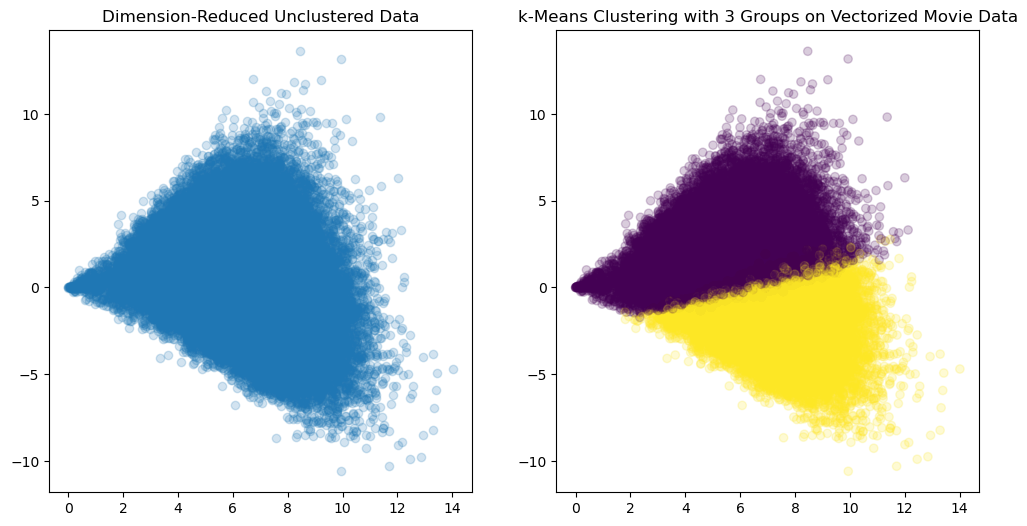

In [30]:
# plot resulting clustering
plot_compare(X_chunked, y_pred, 'k-Means Clustering with 2 Groups on Vectorized Movie Data')

Since the Within-Cluster-Sum-of-Squares (WCSS) does not seem to show a clear elbow during the KMeans analysis, we realized that KMeans might not be the best algorithm to try and determine patterns or clusters in the data. Since there is no distinct elbow, interpretation is also much less straightforward. Therefore, it is difficult to try to support or reject the hypotheses set out at the onset of the KMeans analysis. Thus, we decided to go ahead with other, more specific data processing techniques in hopes of learning other takeawys with the data beyond an unsupervised approach.

# 4. Baseline Supervised Classification Task for Winner vs Loser Classification 

We aimed to apply two commonly used supervised classification methods (Logistic Regression and Random Forest) in 3 slightly modified methods (unigram token features, 200 token chunk features, stopword removal) to set a baseline understanding of whether classifying movies into winner or loser categories for the Academy Awards Best Original Screenplay was possible, and attempt to understand that of the 3 methods, which performed the best what we could learn from their performance.

## I. Using Top 100 Unigram Token Features

#### Identifying the top 100 features
Referenced PS2 method - performed a feature reduction, selectng the top 100 features using a random forest selector to reduce the number of features fed into the model - this was to help address dimentionality issues that could have arisen.

In [30]:
# Create a Vectorizer
vectorizer = TfidfVectorizer(use_idf=True)
X = vectorizer.fit_transform(movie_subtitles_df['text'])

# Convert the TF-IDF matrix to a DataFrame
features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Set features and labels
labels = movie_subtitles_df['Win or Loss']
features = features

# Display the shapes of features and labels
print('Features Shape:', features.shape, 'Labels Shape:', labels.shape)

Features Shape: (355, 53266) Labels Shape: (355,)


In [31]:
# Train the model on the full feature set
rf_full = RandomForestClassifier()
rf_full.fit(features, labels)

# Get feature importances
importances = rf_full.feature_importances_
indices = importances.argsort()[::-1]

# Select the top 100 features
top_100_features_rf = np.array(vectorizer.get_feature_names_out())[indices][:100]
print("Top 100 features (Random Forest):", top_100_features_rf)

Top 100 features (Random Forest): ['dieu' 'sting' 'after' 'lap' 'listen' 'cutters' 'sheet' 'drivin' 'lettin'
 'named' 'pulled' 'is' 'replay' 'two' 'sang' 'regretted' 'band' 'peaches'
 'using' 'gallons' 'sew' 'put' 'ohio' 'meetin' 'bay' 'matilde' 'cooler'
 'at' 'choking' 'explained' 'convert' 'uppers' 'also' 'bride' 'jump'
 'rejoice' 'this' 'ahold' 'louise' 'elevator' 'unless' 'dad' 'sistine'
 'going' 'total' 'trying' 'feel' 'acting' 'francisco' 'dan' 'children'
 'em' 'explanation' 'riot' 'each' 'haze' 'pilferage' 'music' 'tellin'
 'fork' 'faced' 'chairs' 'patrick' 'wilson' 'freaks' 'howl' 'cities'
 'hiya' 'remarkable' 'darned' 'drop' 'motivated' 'gossip' 'humbly' 'blows'
 'thuds' 'speaking' 'professor' 'solutions' 'divisions' 'as' 'home'
 'lessons' 'exhibition' 'such' 'cool' 'pomona' 'distribution' 'working'
 'yogurt' 'third' 'antwerp' 'shock' 'play' 'slim' 'headlines' 'rundstedt'
 'wonder' 'setup' 'doll']


In [32]:
X_top_100 = features[top_100_features_rf]
y = labels

### Logistic Regression

In [33]:
# Train test val split
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X_top_100, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.5, random_state=42)

# Extract NumPy arrays from DataFrames
X_train_array = X_train.values
X_val_array = X_val.values
X_test_array = X_test.values

In [34]:
# Train logistic regression model on data
logreg_clf = LogisticRegression(max_iter=10000).fit(X_train_array, y_train)

# Predict on the validation data
y_val_pred = logreg_clf.predict(X_val_array)
print(classification_report(y_val, y_val_pred, zero_division = 1))

              precision    recall  f1-score   support

         0.0       0.81      1.00      0.89       100
         1.0       1.00      0.00      0.00        24

    accuracy                           0.81       124
   macro avg       0.90      0.50      0.45       124
weighted avg       0.84      0.81      0.72       124



In [35]:
# Predict on test set
y_test_pred = logreg_clf.predict(X_test_array)
print(classification_report(y_test, y_test_pred, zero_division = 1))

              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89        86
         1.0       1.00      0.00      0.00        21

    accuracy                           0.80       107
   macro avg       0.90      0.50      0.45       107
weighted avg       0.84      0.80      0.72       107



### Random Forest

In [36]:
# Train random forest  classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_array, y_train)

RandomForestClassifier(random_state=42)

In [37]:
# Predict on validation set
rf_val_predictions = rf_clf.predict(X_val_array)
print(classification_report(y_val, rf_val_predictions, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90       100
         1.0       1.00      0.08      0.15        24

    accuracy                           0.82       124
   macro avg       0.91      0.54      0.53       124
weighted avg       0.85      0.82      0.76       124



In [38]:
# Predict on test set
rf_test_predictions = rf_clf.predict(X_test_array)
print(classification_report(y_test, rf_test_predictions, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89        86
         1.0       1.00      0.00      0.00        21

    accuracy                           0.80       107
   macro avg       0.90      0.50      0.45       107
weighted avg       0.84      0.80      0.72       107



## II. Using Token Chunk Features

#### Pre-processing and creating train test split

In [39]:
X = text_chunks
y = chunk_win_loss

In [40]:
# Train test val Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

I set a 70%, 15%, 15% split for training, test, and validation sets, respectively. I also introduced stratification of the datasets to maintain the distribution of classes in each subset.

In [41]:
baseline_classification_vectorizer = TfidfVectorizer(use_idf=True, norm=None)

In [42]:
X_train_transformed = baseline_classification_vectorizer.fit_transform(X_train)
X_test_transformed = baseline_classification_vectorizer.transform(X_test)
X_val_transformed = baseline_classification_vectorizer.transform(X_val)

### Logistic Regression

In [43]:
# Train logistic regression classifier
logreg_clf = LogisticRegression(max_iter = 10000).fit(X_train_transformed, y_train)

In [44]:
# Predict on validation set
logreg_val_predictions = logreg_clf.predict(X_val_transformed)
print(classification_report(y_val, logreg_val_predictions, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87     10720
         1.0       0.52      0.53      0.52      2848

    accuracy                           0.80     13568
   macro avg       0.70      0.70      0.70     13568
weighted avg       0.80      0.80      0.80     13568



In [45]:
# Predict on test set
logreg_test_predictions = logreg_clf.predict(X_test_transformed)
print(classification_report(y_test, logreg_test_predictions, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87     10720
         1.0       0.51      0.54      0.53      2849

    accuracy                           0.80     13569
   macro avg       0.69      0.70      0.70     13569
weighted avg       0.80      0.80      0.80     13569



It seems as though the logistic regression classifier is essentially predicting that all movie scripts will lose and not win the Academy Award for Best Original Screenplay. 

### Random Forest

In [46]:
# Train random forest  classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_transformed, y_train)

RandomForestClassifier(random_state=42)

In [47]:
# Predict on validation set
rf_val_predictions = rf_clf.predict(X_val_transformed)
print(classification_report(y_val, rf_val_predictions, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91     10720
         1.0       0.88      0.27      0.42      2848

    accuracy                           0.84     13568
   macro avg       0.86      0.63      0.66     13568
weighted avg       0.85      0.84      0.80     13568



In [48]:
# Predict on test set
rf_test_predictions = rf_clf.predict(X_test_transformed)
print(classification_report(y_test, rf_test_predictions, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91     10720
         1.0       0.89      0.28      0.43      2849

    accuracy                           0.84     13569
   macro avg       0.86      0.64      0.67     13569
weighted avg       0.85      0.84      0.81     13569



## III. Same as Part 5, but with Stopword Removal

In [49]:
# Create vectorizer with stop word removal
stopword_removal_classification_vectorizer = TfidfVectorizer(use_idf=True, stop_words = 'english')

In [50]:
X_train_transformed = stopword_removal_classification_vectorizer.fit_transform(X_train)
X_test_transformed = stopword_removal_classification_vectorizer.transform(X_test)
X_val_transformed = stopword_removal_classification_vectorizer.transform(X_val)

### Logistic Regression

In [51]:
# Train logistic regression classifier
logreg_clf = LogisticRegression(max_iter = 10000).fit(X_train_transformed, y_train)

In [52]:
# Predict on validation set
logreg_val_predictions = logreg_clf.predict(X_val_transformed)
print(classification_report(y_val, logreg_val_predictions, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.82      0.99      0.90     10720
         1.0       0.89      0.20      0.33      2848

    accuracy                           0.83     13568
   macro avg       0.86      0.60      0.61     13568
weighted avg       0.84      0.83      0.78     13568



In [53]:
# Predict on test set
logreg_test_predictions = logreg_clf.predict(X_test_transformed)
print(classification_report(y_test, logreg_test_predictions, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.82      0.99      0.90     10720
         1.0       0.90      0.20      0.33      2849

    accuracy                           0.83     13569
   macro avg       0.86      0.60      0.61     13569
weighted avg       0.84      0.83      0.78     13569



### Random Forest

In [54]:
# Train random forest  classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_transformed, y_train)

RandomForestClassifier(random_state=42)

In [55]:
# Predict on validation set
rf_val_predictions = rf_clf.predict(X_val_transformed)
print(classification_report(y_val, rf_val_predictions, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.85      0.99      0.91     10720
         1.0       0.86      0.32      0.47      2848

    accuracy                           0.85     13568
   macro avg       0.85      0.65      0.69     13568
weighted avg       0.85      0.85      0.82     13568



In [56]:
# Predict on test set
rf_test_predictions = rf_clf.predict(X_test_transformed)
print(classification_report(y_test, rf_test_predictions, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91     10720
         1.0       0.85      0.34      0.49      2849

    accuracy                           0.85     13569
   macro avg       0.85      0.66      0.70     13569
weighted avg       0.85      0.85      0.82     13569



## Section Summary

In all 3 sections, we kept it consistent with a TFIDF vectorizer with IDF turned on. All in all though, it seems that random forest performs better than logistic regression on average, 200 token chunk features result in better predictions than token unigrams, and as hypothesized earlier, removal of stopwords also aids in accuracy of prediction. These results could possibly indicate the importance of context, as 200-word chunks may better preserve the semantic context of the text compared to isolated token unigrams. By grouping words together, chunks might capture more meaningful phrases and expressions, providing richer contextual information for classification. At the same time, chunks can help mitigate the downsides of feature sparsity, which can be a negative when inputting full texts as features. Overall, the baseline tests are very effective at predicting win/loss of a movie. Therefore, we did not feel that an application of BERT here was necessary for this processing.

(also, not shown here, but prior to running classification using token chunks as features, we used entire movie subtitles as features, and saw worse performance, with weighted average scores hovering around 0.7 for both logistic regression and random forest classifiers)

# 5. Baseline Supervised Classification Task for Decade Classification

In [57]:
#decades 
forties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1940') & (movie_subtitles_df['years'] < '1950')]
fifties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1950') & (movie_subtitles_df['years'] < '1960')]
sixties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1960') & (movie_subtitles_df['years'] < '1970')]
seventies = movie_subtitles_df[(movie_subtitles_df['years'] >= '1970') & (movie_subtitles_df['years'] < '1980')]
eighties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1980') & (movie_subtitles_df['years'] < '1990')]
ninties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1990') & (movie_subtitles_df['years'] < '2000')]
twenty = movie_subtitles_df[(movie_subtitles_df['years'] >= '2000') & (movie_subtitles_df['years'] < '2010')]
twenty_ten = movie_subtitles_df[(movie_subtitles_df['years'] >= '2010') & (movie_subtitles_df['years'] < '2020')]
twenty_twenty = movie_subtitles_df[(movie_subtitles_df['years'] >= '2020') & (movie_subtitles_df['years'] < '2030')]

In [58]:
# Assign labels to each decade
forties.loc[:, 'decade'] = '1940s'
fifties.loc[:, 'decade'] = '1950s'
sixties.loc[:, 'decade'] = '1960s'
seventies.loc[:, 'decade'] = '1970s'
eighties.loc[:, 'decade'] = '1980s'
ninties.loc[:, 'decade'] = '1990s'
twenty.loc[:, 'decade'] = '2000s'
twenty_ten.loc[:, 'decade'] = '2010s'
twenty_twenty.loc[:, 'decade'] = '2020s'

# Concatenate the DataFrames
decades = pd.concat([forties, fifties, sixties, seventies, eighties, ninties, twenty, twenty_ten, twenty_twenty])

# Generate chunks
text_chunks, chunk_movie_name, chunk_decades, chunk_win_loss = generate_chunks(
    decades['text'],
    decades['Similarity Calc Name'],
    decades['decade'],
    decades['Win or Loss']
)

# Features
X = stopword_removal_classification_vectorizer.fit_transform(text_chunks)
y = chunk_decades

/var/folders/qy/mhlfbdm940n8kbpppfc_whdh0000gn/T/ipykernel_16109/3597684698.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forties.loc[:, 'decade'] = '1940s'
/var/folders/qy/mhlfbdm940n8kbpppfc_whdh0000gn/T/ipykernel_16109/3597684698.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fifties.loc[:, 'decade'] = '1950s'
/var/folders/qy/mhlfbdm940n8kbpppfc_whdh0000gn/T/ipykernel_16109/3597684698.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

#### Top 10 Features From Each Decade

In [59]:
top_15_features_by_decade = {}

# Iterate over each decade
for decade in ['1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']:
    # Extract data for the current decade
    subset_decade = decades[decades['decade'] == decade]
    
    # Features
    X_tfidf = stopword_removal_classification_vectorizer.fit_transform(subset_decade['text'])

    # Get the feature names
    feature_names = np.array(stopword_removal_classification_vectorizer.get_feature_names_out())

    # Get the sum of TF-IDF values for each feature
    feature_sums = X_tfidf.sum(axis=0).A1

    # Get the indices of top 15 features
    top_15_feature_indices = feature_sums.argsort()[::-1][:15]

    # Get the actual feature names for the top 15 features
    top_15_features = [feature_names[i] for i in top_15_feature_indices]

    # Store the top 15 features for the current decade
    top_15_features_by_decade[decade] = top_15_features

    # Print the top 15 features for the current decade
    print(f"\nTop 15 features for {decade}:")
    for i, feature in enumerate(top_15_features):
        print(f"Index: {top_15_feature_indices[i]}, Feature: {feature}")


Top 15 features for 1940s:
Index: 3930, Feature: don
Index: 7479, Feature: ll
Index: 7095, Feature: know
Index: 10590, Feature: right
Index: 7409, Feature: like
Index: 13994, Feature: yes
Index: 5492, Feature: good
Index: 2667, Feature: come
Index: 8767, Feature: oh
Index: 13374, Feature: ve
Index: 6955, Feature: just
Index: 5512, Feature: got
Index: 11488, Feature: sir
Index: 8332, Feature: mr
Index: 12683, Feature: think

Top 15 features for 1950s:
Index: 4060, Feature: don
Index: 7725, Feature: ll
Index: 7351, Feature: know
Index: 7635, Feature: like
Index: 5721, Feature: got
Index: 7213, Feature: just
Index: 13904, Feature: ve
Index: 10928, Feature: right
Index: 2748, Feature: come
Index: 9026, Feature: oh
Index: 5698, Feature: good
Index: 14539, Feature: yes
Index: 7578, Feature: let
Index: 14112, Feature: want
Index: 13111, Feature: think

Top 15 features for 1960s:
Index: 3461, Feature: don
Index: 6573, Feature: ll
Index: 6276, Feature: know
Index: 2361, Feature: come
Index: 65

In this section, we iterate through each decade, vectorize the text from the decade's subset of text, pull the feature names out, sort them from most to least important, then print out the top fifteen features. The results seem to indicate that commonly used words in dialogue are highly representative of all decades. This is plausible since dialogue is the main form of communication in all movies. Though, it is a little strange that they are so similar. We tested a variety of methods to try and understand why this was happening, but were ultimately unsuccessful given our time limitations to complete this project. However, since they are so similar, this could feasibly lead to some difficulty making accurate predictions.

## Random Forest Decade Classification

We started with random forest classification since it performed the best on the win/loss predictions. For consistency, we also used the same vectorizer.

In [60]:
# Train test val Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [61]:
# Train the random forest classifier
rf_clf.fit(X_train, y_train)

# Predict on the test set
rf_decade_pred = rf_clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, rf_decade_pred, zero_division=1))

              precision    recall  f1-score   support

       1940s       0.46      0.48      0.47      1327
       1950s       0.46      0.41      0.43      1358
       1960s       0.69      0.27      0.39       971
       1970s       0.47      0.31      0.37      1498
       1980s       0.35      0.38      0.36      1783
       1990s       0.35      0.50      0.41      2084
       2000s       0.44      0.33      0.38      1778
       2010s       0.42      0.61      0.50      2150
       2020s       0.89      0.20      0.33       620

    accuracy                           0.42     13569
   macro avg       0.50      0.39      0.40     13569
weighted avg       0.46      0.42      0.41     13569



## Logistic Regression Decade Classification

In [62]:
# Train the logistic regression classifier
logreg_clf.fit(X_train, y_train)

# Predict on the test set
logreg_decade_pred = logreg_clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, logreg_decade_pred, zero_division=1))

              precision    recall  f1-score   support

       1940s       0.56      0.58      0.57      1327
       1950s       0.56      0.54      0.55      1358
       1960s       0.64      0.38      0.48       971
       1970s       0.52      0.44      0.48      1498
       1980s       0.48      0.48      0.48      1783
       1990s       0.47      0.58      0.52      2084
       2000s       0.51      0.49      0.50      1778
       2010s       0.52      0.66      0.58      2150
       2020s       0.83      0.30      0.45       620

    accuracy                           0.52     13569
   macro avg       0.57      0.50      0.51     13569
weighted avg       0.54      0.52      0.52     13569



### Visualization of Logistic Regression Predictions (prediction done on entire dataset for simplicity's sake)

In [63]:
# Dataframe
year_pred_df = pd.DataFrame({
    'decade': y_test,
    'logreg_decade_pred': logreg_decade_pred
})

year_pred_df['decade'] = year_pred_df['decade'].astype(str)

year_pred_df = year_pred_df.sort_values(by='decade')

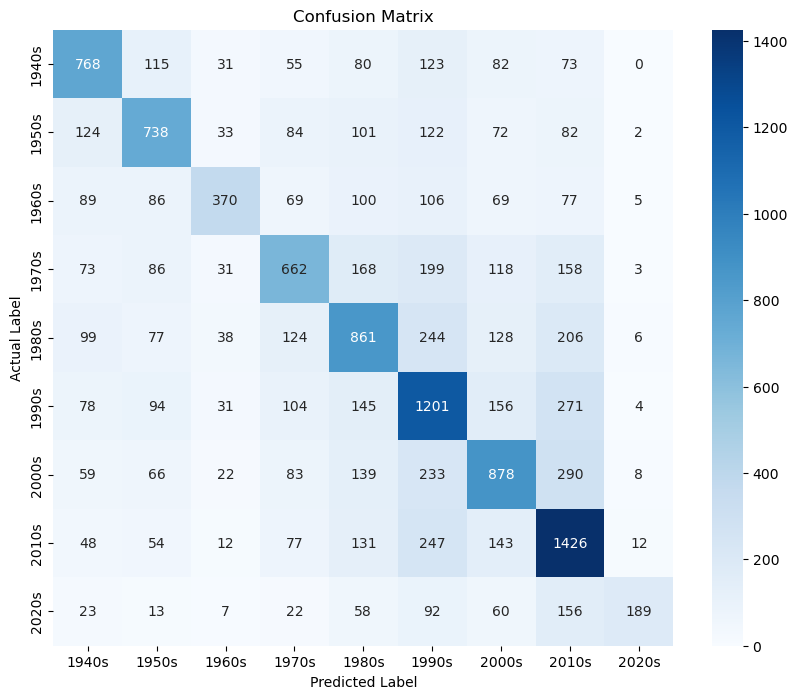

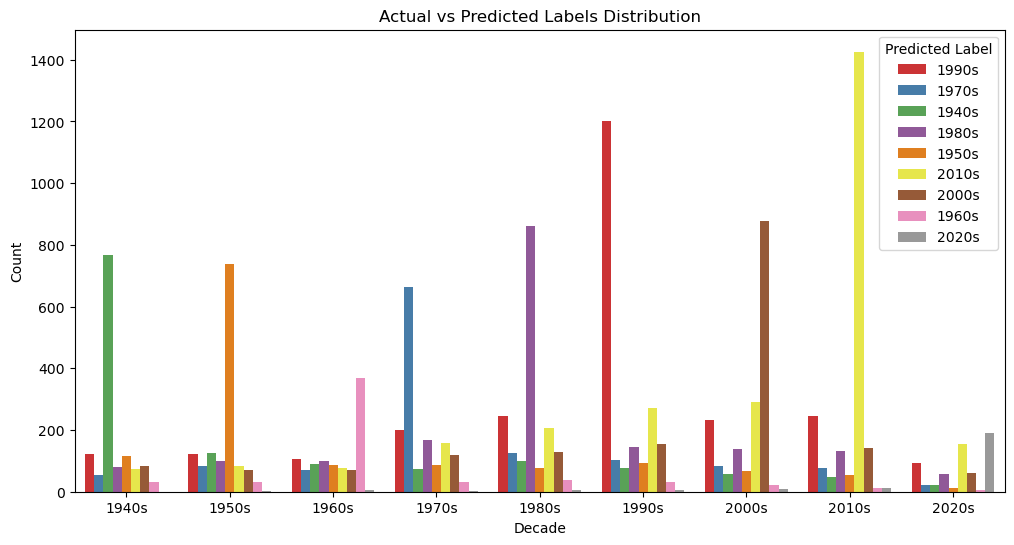

In [64]:
conf_matrix = confusion_matrix(y_test, logreg_decade_pred)

# Visualization 1: Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# Visualization 3: Bar Plot of Actual vs Predicted Labels
plt.figure(figsize=(12, 6))
sns.countplot(x='decade', hue='logreg_decade_pred', data=year_pred_df, palette='Set1')
plt.title('Actual vs Predicted Labels Distribution')
plt.xlabel('Decade')
plt.ylabel('Count')
plt.legend(title='Predicted Label')
plt.show()

When predicting decades, accuracy scores are far lower than when predicting win/loss when tested with a train test split. Our theory is that this could potentially be caused by a number of factors, including lesser differentiating factors between decades than between winning/losing scripts or perhaps just a smaller dataset to train and test on. In addition, interestingly, in terms of F1 score on the logistic regression model, the decade with the most data points did the best and the decade with the least data points did the worst. In the visualizations, the model seems to do better due to a larger volume of input data. Regardless, these baseline results could merit further testing with neural methods to see if any improvement can be made.

# 6. BERT Classification Task for Decade Classification

In [65]:
X = text_chunks
y = chunk_decades

# Train test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [66]:
model_name = 'distilbert-base-cased'
device_name = 'mps'

# This is the maximum number of tokens in any document sent to BERT.
max_length = 512

In [67]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
tokenized_scripts = tokenizer(text_chunks, truncation=True, padding=True, return_tensors="pt")

In [68]:
unique_labels = set(label for label in y_train)
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

In [69]:
# Load pre-trained BERT model
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label)).to(device_name)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight

In [70]:
# Encoding texts and labels for tokenizer
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(X_test, truncation=True, padding=True, max_length=max_length)
validation_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=max_length)

train_labels_encoded = [label2id[y] for y in y_train]
test_labels_encoded  = [label2id[y] for y in y_test]
val_labels_encoded = [label2id[y] for y in y_val]

In [71]:
# Convert encoded texts and labels into a dataset object
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MyDataset(train_encodings, train_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)
validation_dataset = MyDataset(validation_encodings, val_labels_encoded)

In [72]:
# Set training parameters
training_args = TrainingArguments(
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=15,  # batch size per device during training
    per_device_eval_batch_size=12,   # batch size for evaluation
    learning_rate=1e-5,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,               # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

In [73]:
# Evaluation function that returns F1 score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    #score = accuracy_score(labels, preds)
    score = f1_score(labels, preds, average='weighted')
    return {
          'f1': score,
      }

In [75]:
# Create HuggingFace Trainer Object
trainer = Trainer(
    model=model,              # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=validation_dataset,     # evaluation dataset
    compute_metrics=compute_metrics      # our custom evaluation function
)

In [90]:
# # Train the model
# trainer.train()

In [ ]:
# # Predict results based on Validation Dataset
# predicted_results = trainer.predict(validation_dataset)
# predicted_labels = predicted_results.predictions.argmax(-1) # Get the highest probability prediction
# predicted_labels = predicted_labels.flatten().tolist()      # Flatten the predictions into a 1D list
# predicted_labels = [id2label[l] for l in predicted_labels]  # Convert from integers back to strings for readability
# print(classification_report(y_val, predicted_labels))

In [ ]:
# # Apply fine-tuned model to Test Dataset
# predicted_results = trainer.predict(test_dataset)
# predicted_labels = predicted_results.predictions.argmax(-1) # Get the highest probability prediction
# predicted_labels = predicted_labels.flatten().tolist()      # Flatten the predictions into a 1D list
# predicted_labels = [id2label[l] for l in predicted_labels]  # Convert from integers back to strings for readability

# print(classification_report(y_test, predicted_labels))

The BERT model is predicted to take 19 hours to run, so this idea was unfortunately unable to be executed in its entirety.

# 6. Sentiment Analysis over the decades

For this analysis, we will be looking into the different sentiments within the decades, but also within the winners and losers of our dataset. 

In [77]:
#decades 
forties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1940') & (movie_subtitles_df['years'] < '1950')]
fifties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1950') & (movie_subtitles_df['years'] < '1960')]
sixties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1960') & (movie_subtitles_df['years'] < '1970')]
seventies = movie_subtitles_df[(movie_subtitles_df['years'] >= '1970') & (movie_subtitles_df['years'] < '1980')]
eighties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1980') & (movie_subtitles_df['years'] < '1990')]
ninties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1990') & (movie_subtitles_df['years'] < '2000')]
twenty = movie_subtitles_df[(movie_subtitles_df['years'] >= '2000') & (movie_subtitles_df['years'] < '2010')]
twenty_ten = movie_subtitles_df[(movie_subtitles_df['years'] >= '2010') & (movie_subtitles_df['years'] < '2020')]
twenty_twenty = movie_subtitles_df[(movie_subtitles_df['years'] >= '2020') & (movie_subtitles_df['years'] < '2030')]

In [78]:
years = [forties, fifties, sixties, seventies, eighties, ninties, twenty, twenty_ten, twenty_twenty]

In [79]:
def sentiment_score(vader, text_string, name):
    sentiment_dict = vader.polarity_scores(text_string)
    overall_sentiment = 'positive' if sentiment_dict['compound'] >= 0.05 else 'negative' if sentiment_dict['compound'] <= -0.05 else 'neutral'
    return sentiment_dict['pos'], sentiment_dict['neg']

In [80]:
#compiling sentiment scores for decades 
names = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
ind = 0
pos_neg = {}
for year in years:
    analyzer = SentimentIntensityAnalyzer()
    pos_list, neg_list = [], []
    for text,movie in zip(year['text'], year['Movie Name']):
        pos, neg = sentiment_score(analyzer, str(text), movie)
        pos_list.append(pos)
        neg_list.append(neg)
    pos_neg[f"{names[ind]}_pos"] = pos_list
    pos_neg[f"{names[ind]}_neg"] = neg_list
    ind += 1

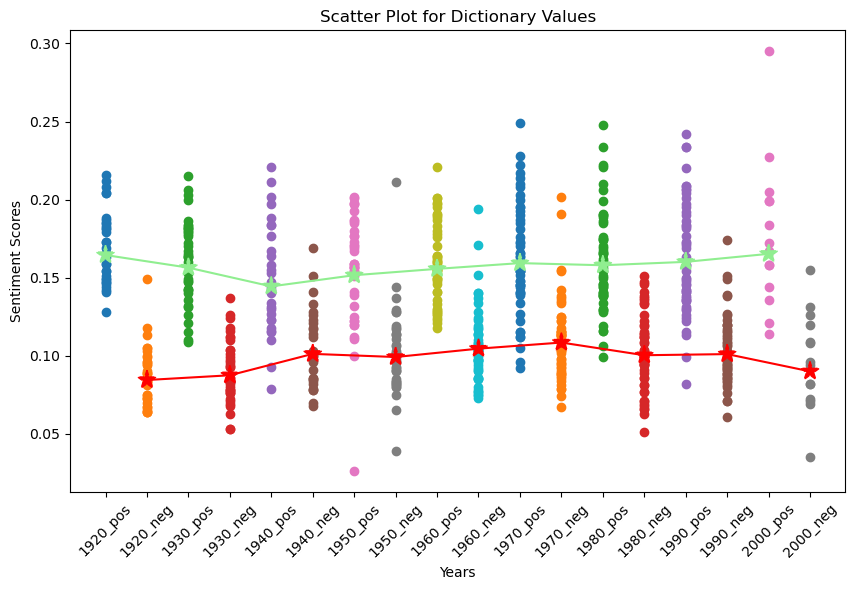

In [81]:
plt.figure(figsize=(10, 6))
plt.title('Scatter Plot for Dictionary Values')
plt.xticks(rotation=45)
plt.xlabel('Years')
plt.ylabel('Sentiment Scores')

for key, values in pos_neg.items():
    plt.scatter([key] * len(values), values, label=key)

x_values_pos, average_tokens_values_pos = [], []
x_values_neg, average_tokens_values_neg = [], []

for key, values in pos_neg.items():
    if 'pos' in key: 
        average_tokens = sum(values)/(len(values)+1)
        plt.scatter(x=key, y=average_tokens, color='lightgreen', linestyle='--', label='Average Tokens',marker ='*', s=200)    
        x_values_pos.append(key)
        average_tokens_values_pos.append(average_tokens)
    if 'neg' in key:
        average_tokens = sum(values)/(len(values)+1)
        plt.scatter(x=key, y=average_tokens, color='red', linestyle='--', label='Average Tokens',marker ='*', s=200)    
        x_values_neg.append(key)
        average_tokens_values_neg.append(average_tokens)

plt.plot(x_values_pos, average_tokens_values_pos, color='lightgreen', linestyle='-', marker='o', markersize=5)
plt.plot(x_values_neg, average_tokens_values_neg, color='red', linestyle='-', marker='o', markersize=5)

plt.show()

In [82]:
#winners or losers 
winners = movie_subtitles_df[(movie_subtitles_df['Win or Loss'] == 1)]
losers = movie_subtitles_df[(movie_subtitles_df['Win or Loss'] == 0)]

In [83]:
names = ['wins', 'losses']
ind = 0
# pos_list, neg_list = [], []
win_loss = {}
for group in [winners, losers]:
    analyzer = SentimentIntensityAnalyzer()
    pos_list, neg_list = [], []
    for text, movie in zip(group['text'], group['Movie Name']):
        pos, neg = sentiment_score(analyzer, str(text), movie)
        pos_list.append(pos)
        neg_list.append(neg)
    win_loss[f"{names[ind]}_pos"] = pos_list
    win_loss[f"{names[ind]}_neg"] = neg_list
    ind += 1

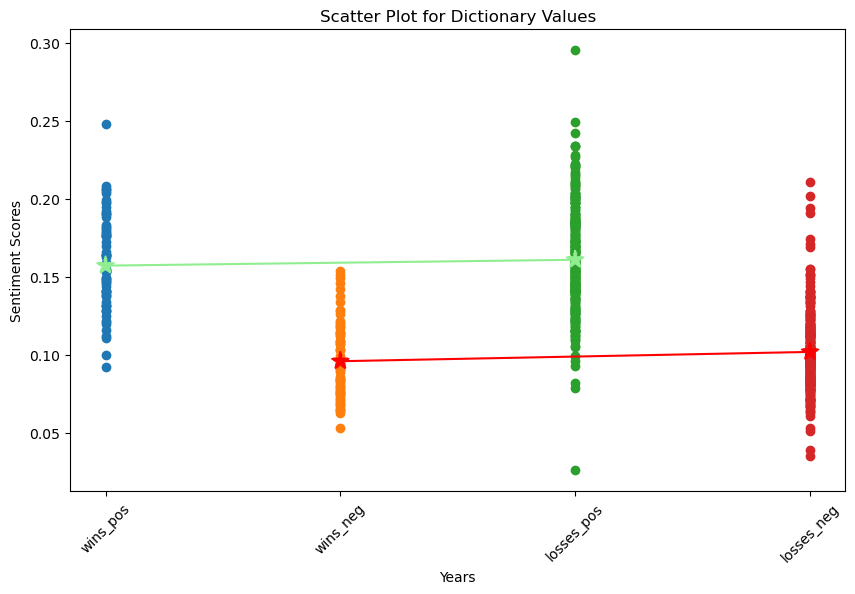

In [84]:
plt.figure(figsize=(10, 6))
plt.title('Scatter Plot for Dictionary Values')
plt.xticks(rotation=45)
plt.xlabel('Years')
plt.ylabel('Sentiment Scores')
for key, values in win_loss.items():
    plt.scatter([key] * len(values), values, label=key)

x_values_pos, average_tokens_values_pos = [], []
x_values_neg, average_tokens_values_neg = [], []

for key, values in win_loss.items():
    if 'pos' in key: 
        average_tokens = sum(values)/(len(values)+1)
        plt.scatter(x=key, y=average_tokens, color='lightgreen', linestyle='--', label='Average Tokens',marker ='*', s=200)    
        x_values_pos.append(key)
        average_tokens_values_pos.append(average_tokens)
    if 'neg' in key:
        average_tokens = sum(values)/(len(values)+1)
        plt.scatter(x=key, y=average_tokens, color='red', linestyle='--', label='Average Tokens',marker ='*', s=200)    
        x_values_neg.append(key)
        average_tokens_values_neg.append(average_tokens)

plt.plot(x_values_pos, average_tokens_values_pos, color='lightgreen', linestyle='-', marker='o', markersize=5)
plt.plot(x_values_neg, average_tokens_values_neg, color='red', linestyle='-', marker='o', markersize=5)
    
plt.show()

Now, we will perform the same analysis but using HuggingFace Library Instead. 

In [85]:
def sentiment_scores(text):
    model_name = "distilbert-base-uncased-finetuned-sst-2-english"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    classifier = pipeline("sentiment-analysis", model=model_name, tokenizer=tokenizer)
    shortened_text = text[2000:2512]
    results = classifier(shortened_text)
    
    positive_score = 0
    negative_score = 0

    for result in results:
        label = result['label'].lower()
        if label == 'positive':
            positive_score += result['score']
        elif label == 'negative':
            negative_score += result['score']

    return positive_score, negative_score

In [86]:
names = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
pos_neg = {}
ind = 0
for year in years:
    pos_list, neg_list = [], []
    
    for text, movie in zip(year['text'], year['Movie Name']):
        pos_score, neg_score = sentiment_scores(str(text))
        pos_list.append(pos_score)
        neg_list.append(neg_score)

    pos_neg[f"{names[ind]}_pos"] = pos_list
    pos_neg[f"{names[ind]}_neg"] = neg_list
    ind += 1

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


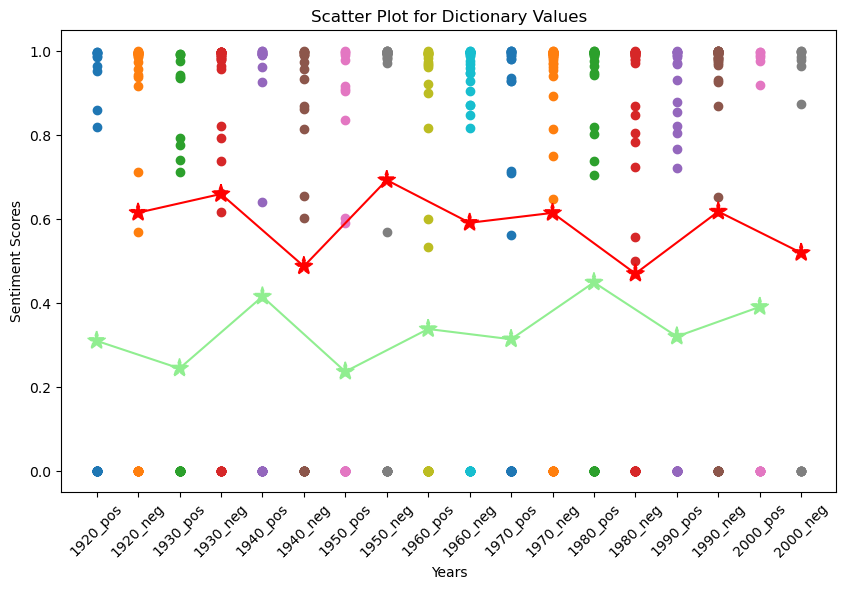

In [87]:
plt.figure(figsize=(10, 6))
plt.title('Scatter Plot for Dictionary Values')
plt.xticks(rotation=45)
plt.xlabel('Years')
plt.ylabel('Sentiment Scores')

for key, values in pos_neg.items():
    plt.scatter([key] * len(values), values, label=key)

x_values_pos, average_tokens_values_pos = [], []
x_values_neg, average_tokens_values_neg = [], []

for key, values in pos_neg.items():
    if 'pos' in key: 
        average_tokens = sum(values)/(len(values)+1)
        plt.scatter(x=key, y=average_tokens, color='lightgreen', linestyle='--', label='Average Tokens',marker ='*', s=200)    
        x_values_pos.append(key)
        average_tokens_values_pos.append(average_tokens)
    if 'neg' in key:
        average_tokens = sum(values)/(len(values)+1)
        plt.scatter(x=key, y=average_tokens, color='red', linestyle='--', label='Average Tokens',marker ='*', s=200)    
        x_values_neg.append(key)
        average_tokens_values_neg.append(average_tokens)

plt.plot(x_values_pos, average_tokens_values_pos, color='lightgreen', linestyle='-', marker='o', markersize=5)
plt.plot(x_values_neg, average_tokens_values_neg, color='red', linestyle='-', marker='o', markersize=5)
     
    
plt.show()

In [88]:
names = ['wins', 'losses']
win_loss = {}
ind = 0
for group in [winners, losers]:
    pos_list, neg_list = [], []
    
    for text, movie in zip(group['text'], group['Movie Name']):
        pos_score, neg_score = sentiment_scores(str(text))
        pos_list.append(pos_score)
        neg_list.append(neg_score)

    win_loss[f"{names[ind]}_pos"] = pos_list
    win_loss[f"{names[ind]}_neg"] = neg_list
    ind += 1

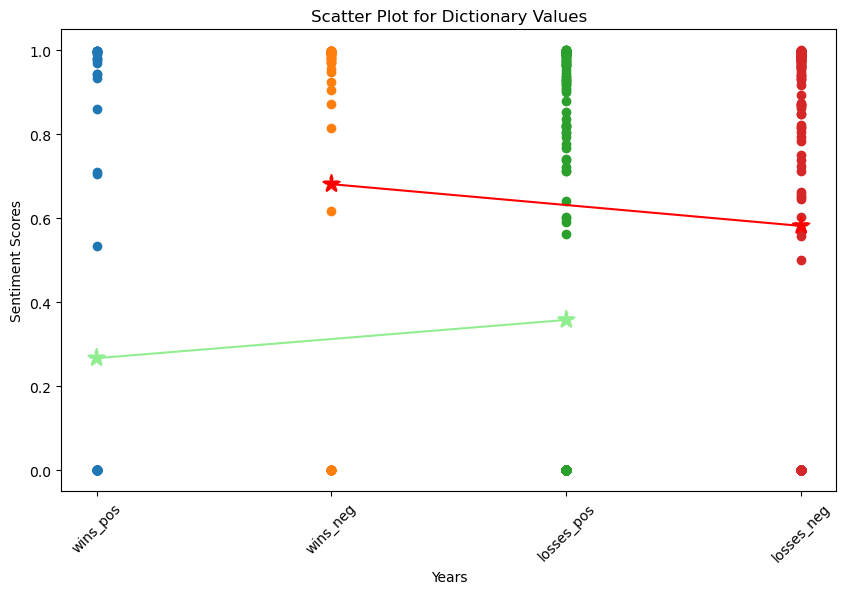

In [89]:
plt.figure(figsize=(10, 6))
plt.title('Scatter Plot for Dictionary Values')
plt.xticks(rotation=45)
plt.xlabel('Years')
plt.ylabel('Sentiment Scores')
for key, values in win_loss.items():
    plt.scatter([key] * len(values), values, label=key)

x_values_pos, average_tokens_values_pos = [], []
x_values_neg, average_tokens_values_neg = [], []

for key, values in win_loss.items():
    if 'pos' in key: 
        average_tokens = sum(values)/(len(values)+1)
        plt.scatter(x=key, y=average_tokens, color='lightgreen', linestyle='--', label='Average Tokens',marker ='*', s=200)    
        x_values_pos.append(key)
        average_tokens_values_pos.append(average_tokens)
    if 'neg' in key:
        average_tokens = sum(values)/(len(values)+1)
        plt.scatter(x=key, y=average_tokens, color='red', linestyle='--', label='Average Tokens',marker ='*', s=200)    
        x_values_neg.append(key)
        average_tokens_values_neg.append(average_tokens)

plt.plot(x_values_pos, average_tokens_values_pos, color='lightgreen', linestyle='-', marker='o', markersize=5)
plt.plot(x_values_neg, average_tokens_values_neg, color='red', linestyle='-', marker='o', markersize=5)    
    
plt.show()

### Sentiment Analysis Reflection 

When continuing on with the analysis of our movies, my group thought it would be fitting to do a sentiment analysis to attempt to find different trends over time. Additionally, we wanted to do sentiment analyses between movies that won awards and those that did not. In order to accomplish this task, we split up the dataset into 1) different decades and 2) winners of awards and losers. When producing a sentiment analysis for the movies over the decades, I first proceeded with the classifier that we used in class: vader. The vader sentiment analysis tool uses a combination of a list of lexical features (i.e., words) which are labeled according to their semantic orientation as either positive or negative. This score is the compounded into a compound score that represents the sentiment of the entire text that was input into the analyzer. However, this tool is specifically attuned to sentiments that are expressed in social media. Because of this fact, we were slighly hesitant on how the classifier would perform on classification with movies. In order to take this classification to the next level, we wanted to attempt to levegerage the HuggingFace library and use a bert sentiment tool in order to get another classification. The next model that we used was the `DistilBERT` model that has been fine-tuned for the sentiment analysis task. Bert is different from Vader in that Bert leverages attention mechanisms to understand the context of words within text. It does so by considering the entire context of a sentence by looking at words that come before and after. The sentiment score using Bert is likley to be more nuanced, as transformer models can capture more complex patterns in text data than rule-based systems like VADER. When interpreting the results of the classifiers, is seems as thought the distributions of the sentiments are not necessarily the same with each classsifer. There are a few reasons why this might be in terms of the classifiers themselves. 
1. VADER is a rule-based model that looks at words individually, often weighting them according to their position in a sentiment lexicon. On the other hand, `DistilBERT` looks at the context around each word, which might result in a different interpretation of sentiment.

2. The `DistilBERT` model has been trained on a corpus of data that likely includes a variety of text sources, while VADER's lexicon is weighted towards social media text. This can result in differing interpretations of sentiment for the same text. Because of this, the `DistilBERT` model might be better suited for a sentiment analysis on movies. 

3. The `DistilBERT` approach takes a snippet of text (512 characters), which might not represent the overall sentiment of the entire text. VADER assesses the sentiment of the entire text string provided. The BERT model is limited in the length of the text that it is able to take in-- preventing a wholistic picture and might be a down fall for this model. 

4. The VADER method aggregates sentiment into a single compound score, simplifying the output to positive, negative, or neutral. The `DistilBERT` model, however, provides a score for each sentiment label, and this analysis sums the scores for all instances labeled as positive or negative.

5. `DistilBERT`'s attention mechanisms allow it to be sensitive to the context in which words are used, which could lead to a different interpretation of the same words compared to VADER's method. The VADER method uses a list of lexical features that are specific to social media-- proving to potentially 

While these factors might begin to explain the differences between the performance of the sentiment analyses, it is important to think about them in the context of the data: movies. Because this dataset is very distinct, I believe that the `DistilBERT` model might be better suited for a sentiment analysis in this case. Below are a couple reasons as to why. 
1. Award-nominated films often have complex storylines with nuanced emotional arcs. A model like DistilBERT is likley be better suited to understand these nuances because of its ability to comprehend context and the interplay of different emotional signals within the text. This could make it more accurate for analyzing the sophisticated narratives of critically acclaimed films.
2.  The sentiment conveyed in movies can be deeply rooted in the cultural and historical context of the time when they were made. Since the VADER sentiment analysis tool is based on a lexicon that may not fully account for historical and cultural shifts in language, its assessments may be less accurate for movies outside of its core temporal and cultural training data.
3. Academy Award-nominated films often feature rich dialogues and monologues that carry a significant emotional weight. A model trained on varied textual data, like DistilBERT, might be better at capturing the sentiment of these complex speech patterns compared to VADER, which may not account for the subtleties of dialogue delivery and emotional undertones.
4. Films that receive critical acclaim often include subtext, irony, or dark humor, which can be challenging for a more straightforward sentiment analysis tool like VADER. DistilBERT and similar transformer models are more likely to grasp such subtleties due to their deeper contextual understanding.
5. The genres of Academy Award-nominated films vary widely, from dramas and historical films to comedies and musicals. Each genre can express sentiment in different ways. DistilBERT's nuanced understanding of context could make it more adaptable across various genres of films.

Although VADER's lexicon-based approach can effectively analyze explicit sentiments, especially in shorter and less complex texts, DistilBERT's context-aware approach may provide a more accurate sentiment analysis for the complex and often subtle narratives found in Academy Award-nominated films.

Going a step further than the fundamental function of these two tools, we want to understand how they actually performed. One way of assessing this is by looking at and analyzing the graphs that we have made in order to visualize the results. 
The distribution of sentiment scores in the VADER graph is more compact, suggesting less variation between movies or a more conservative assessment of sentiment. On the other hand, `DistilBERT` shows a more varied distribution, which might suggest a greater sensitivity to the nuances in the text. In addition to this, we want to observe the trends that the graphs are showing overtime. Both graphs show trends across decades with both positive and negative sentiment scores. However, the trends differ between the two. VADER appears to show a more stable sentiment over time, whereas DistilBERT reflects more variation in sentiment. This could mean that DistilBERT captures the changing nature of film narratives and sentiments over time more dramatically. The interpretation of the graphs may heavily depend on your expectations going into the analysis. Based on my groups understanding of the dataset is that the trends from decade to decade will fluctuate overtime. If we expect that movies' sentiments, especially those nominated for Academy Awards, would vary greatly over time due to changes in societal norms, storytelling styles, and topics, then DistilBERT's results may be seen as more accurate due to their higher variability and potentially deeper understanding of context. Overall, it seems that the `DistilBERT` does a better job of understanding the dataset in the context that it is being shown. The visualizations and sentiment results second this perspective that we are seeing.  

# Conclusions 

**Truncated SVD Analysis:**
- The Truncated Singular Value Decomposition (SVD) did not show any meaningful distinctions between winning and losing scripts. This method, aimed at reducing the dimensionality of the data, was unable to highlight clear patterns or distinguishing features that could differentiate between scripts resulting in wins versus losses. Because there was no apparent distinction in this analysis, our group was left to think that winning or losing might not be a good seperating factor that would lead to finding to distinct groups of text. 

**KMeans Analysis:**
- The KMeans clustering analysis struggled a little bit, with the absence of a elbow pattern within the plot. Typically, the 'elbow method' is employed to identify the optimal number of clusters in the data. The absence of a discernible elbow indicates that KMeans might not be the most appropriate algorithm for finding groups within this dataset. This analysis proved inconclusive in terms of clustering, but helped to support a hypothesis that certain factors we might have expected to be differentiating between scripts are not. 

**Logistic Regression/Random Forrest:**
- Comparative evaluation between logistic regression and random forest models revealed that random forest consistently outperformed logistic regression in predictive accuracy. Specifically, utilizing 200-token chunk features resulted in better predictions compared to using token unigrams. Additionally, the removal of stopwords increased the prediction accuracy.
- The preference for 200-token chunks over isolated unigrams shows us that there is a large importance on the context of the tokens and words given by the words around them in movie scripts than just the tokens themseves. By keeping words surrounded by others, you preserve phrases and context which helps for a better and more descriptivie analysis.

**Feature Representation:**
- Our analysis of the top features was very intersting. We found a very interesting observation, and that is that words that are typically used in dialogue were higly represented across all of the decades. While we did anticipate that communication words that are usually used in dialogue would make up a large part of the analysis, we were concerned with how similar they were across decades. As we know, language consistently changes as time goes on, so these similarities were a little confusing. This left my group with questions, but the conclusion that we came to is that movies are not generally representative of the time they are made. Movies are made about different time periods and therefore would be reflective of the language iteration at that time. This is a reason that could explain the stagnant features over time. 

**Prediction Accuracies:**
- When calculating the prediction accuracies between decades and across winners/losers, there was great descrepency. There was lower prediction accuracy between decades vs win/loss. One reason for the lower prediction accuracy is that there might be less distinguishing factors within decades than movies that are winners/losers. We also noticed that the decade with the most extensive data yielded the best performance, and the decade with the least amount of data performed the words. This defintely supported the notion that more data helps performance. Supporting this, the visualization supported a correlation between model performance and the volume of data. These findings hilighted the need for additional exploration and a deeper analysis. 

**Sentiment Analysis Insights:**
- In exploring sentiment analysis, two methods, VADER and DistilBERT, were employed. VADER showcased limited sentiment variation across decades, while DistilBERT demonstrated a more diverse range of scores. This variance suggests that DistilBERT might be better suited for sentiment analysis, as the model is inherently different and allows for the capturing of context. In addition, there was very little difference-- if any-- between the movies that were winners and losers. Our hypothesis here is that the sentiment analysis is more focused on the content of the movies rather than the syle of writing. We believe that what is being analyzed is the content and what is embedded in the text rather than the style or writing. 

## Appendix

In [ ]:
# Initialize an empty dictionary to store top 10 features for each decade
top_10_features_by_decade = {}

# Iterate over each decade
for decade in decades['decade'].unique():
    # Extract data for the current decade
    subset_decade = decades[decades['decade'] == decade]
    
    # Features
    X = stopword_removal_classification_vectorizer.fit_transform(subset_decade['text'])
    y = subset_decade['decade']

    # Train RandomForestClassifier
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X, y)

    # Get feature importances
    importances = rf_clf.feature_importances_
    feature_names = stopword_removal_classification_vectorizer.get_feature_names_out()

    # Get indices of top 10 features
    top_10_feature_indices = importances.argsort()[::-1][:10]

    # Get the actual feature names for the top 10 features
    top_10_features = [feature_names[i] for i in top_10_feature_indices]

    # Store the top 10 features for the current decade
    top_10_features_by_decade[decade] = top_10_features

    # Print the top 10 features for the current decade
    print(f"Top 10 features for {decade}:")
    for i, feature in enumerate(top_10_features):
        print(f"Index: {top_10_feature_indices[i]}, Feature: {feature}")